In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # Importing odeint for ODE solving

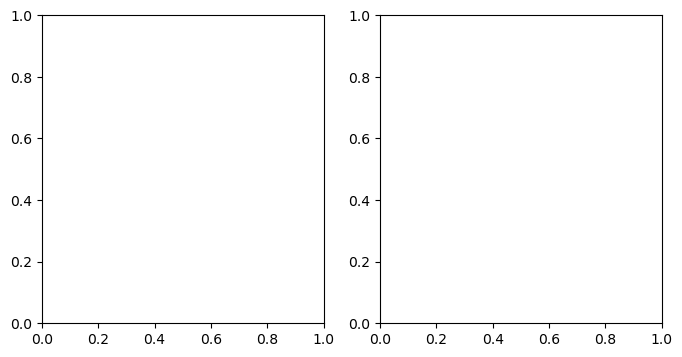

Iter 0001 | Total Loss 141.682159


<Figure size 640x480 with 0 Axes>

Iter 0100 | Total Loss 43.111336


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [9]:
# Set random seeds for reproducibility
torch.manual_seed(1000)
np.random.seed(1000)

# Select device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define parameters
method = 'dopri5'           # ODE solver method
data_size = 1000            # Number of data points
batch_time = 10             # Time steps for each batch
batch_size = 20             # Number of samples per batch
niters = 11100              # Number of training iterations
test_freq = 100             # Frequency of testing
viz = True                  # Enable visualization

# Define the true system (ground truth dynamics)
true_y0 = torch.tensor([[0.1, 0.1]]).to(device)      # Initial state
t = torch.linspace(0., 1000., data_size).to(device)  # Time points
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)  # True system matrix

class Lambda(nn.Module):
    def forward(self, t, y):
        # Define dynamics for the true system
        return torch.mm(y**3, true_A)

# Generate true system data with added noise
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method=method)

# Add Gaussian noise to the true system data
noise_variance = 1e-6
noise = torch.randn(true_y.size()).to(device) * noise_variance**0.5
noisy_y = true_y + noise

# Function to get mini-batch data for training
def get_batch():
    # Randomly select batch indices
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = noisy_y[s]  # Initial condition for each batch
    batch_t = t[:batch_time]  # Time steps for each batch
    batch_y = torch.stack([noisy_y[s + i] for i in range(batch_time)], dim=0)  # Batch data
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Setup visualization (create output directory and plot)
if viz:
    os.makedirs('png', exist_ok=True)
    fig, (ax_traj, ax_phase) = plt.subplots(1, 2, figsize=(8, 4), facecolor='white')
    plt.show(block=False)

# Visualization function to plot trajectories and phase portrait
def visualize(true_y, pred_y, noisy_y, itr):
    if viz:
        # Plot true trajectory, noisy data, and predicted trajectory
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x, y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'g-', label='True System')
        ax_traj.plot(t.cpu().numpy(), noisy_y.cpu().numpy()[:, 0, 0], 'r-', label='Noisy System')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'b--', label='Neural ODE')
        ax_traj.legend()

        # Plot phase portrait
        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')

        fig.tight_layout()
        plt.savefig(f'png/{itr:03d}.png')
        plt.pause(0.001)

# Define the neural ODE model to learn the dynamics
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        # Define a simple feed-forward network
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )
        # Initialize weights and biases
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        # Define the neural ODE dynamics
        return self.net(y**3)

# Training loop
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=2e-5)

for itr in range(1, niters + 1):
    # Get mini-batch data
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)  # Predict dynamics
    loss = torch.mean(torch.abs(pred_y - batch_y))       # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    # Print and visualize at specified intervals
    if itr % test_freq == 0 or itr == 1:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - noisy_y))
            print(f'Iter {itr:04d} | Total Loss {loss.item():.6f}')
            visualize(true_y, pred_y, noisy_y, itr)

# Final visualization with a new initial condition
new_y0 = torch.tensor([[0.15, 0.2]]).to(device)
with torch.no_grad():
    true_y = odeint(Lambda(), new_y0, t, method=method)
    pred_y = odeint(func, new_y0, t)
visualize(true_y, pred_y, noisy_y, itr)
loss = torch.mean(torch.abs(pred_y - true_y))
print(f'Total Loss {loss.item():.6f}')
